In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
# ignore all warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import f1_score,confusion_matrix, roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold

## 1 Load the data set

In [2]:
df = pd.read_csv("~/downloads/corona_tested_individuals_ver_00166.csv", header=0, parse_dates = ['test_date']) ## load the date in local
# df_np = np.loadtxt('corona_tested_individuals_ver_00166.csv', delimiter=',', skiprows=1,
#                           usecols= (1,7), unpack=True)
# df = pd.DataFrame(df)
df.columns = ['date','cough','fever','sore_throat','shortness_of_breath','head_ache','corona_result','age','gender','test_indication']

## 2 Data Exploration¶

Explanation of the data:
https://data.gov.il/dataset/covid-19/resource/0ac4cffc-3746-473a-8d4a-ab874b8d8d62

Gender: appears from March 22nd 2020

Corona_result: Results of first Covid-19 test, by category:
    a.Positive – carrying Covid-19
    b.Negative – not carrying Covid-19
    c.Other – Not tested, in testing, inconclusive

Age_60_and_above: Indicator of the test taker's age - 60 or over (1) or below 60 (0). Appears from March 17th 2020.

Test_indication: What is the indication for testing? Abroad – arrived from abroad, contact_with_confirmed – contact with a confirmed case, other – other indication or not specified

Symptoms (whether developed before testing):
cough, fever, sore_throat, shortness of breath, headache: 1 – Yes, 0 – No, NULL – Unknown

The corona_result is the label class.

In [3]:
df = df[df["date"] > "2021-05-30"] # for simplicity and computability for a laptop, use data after 2021-05-30

In [4]:
df.head()

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
1,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other
2,2021-07-25,1,1,1,0,1,אחר,No,נקבה,Abroad
3,2021-07-25,0,0,0,0,0,שלילי,No,זכר,Other
4,2021-07-25,0,0,0,0,0,שלילי,No,נקבה,Other


In [5]:
df.shape

(486659, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486659 entries, 0 to 486658
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   date                 486659 non-null  datetime64[ns]
 1   cough                486659 non-null  int64         
 2   fever                486659 non-null  int64         
 3   sore_throat          486659 non-null  int64         
 4   shortness_of_breath  486659 non-null  int64         
 5   head_ache            486659 non-null  int64         
 6   corona_result        486659 non-null  object        
 7   age                  201480 non-null  object        
 8   gender               271191 non-null  object        
 9   test_indication      486659 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(4)
memory usage: 40.8+ MB


In [7]:
df.isnull().sum()

date                        0
cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age                    285179
gender                 215468
test_indication             0
dtype: int64

According to the offical documents, testing for the virus started in February. However,due to privacy concerns:
1. The information is available from 11 March 2020.
2. Ages have been divided to under 60 and 60 and over, and are published from 17 March until 14 April (before 17 March until 14 April age equals NULL)
3. Sex is published from 22 March (before the date, sex was represented as NULL)

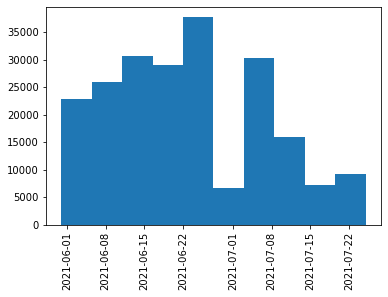

In [8]:
plt.hist(df[df["gender"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

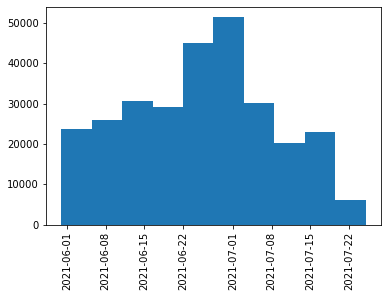

In [9]:
plt.hist(df[df["age"].isnull()]['date'], bins = 10)
plt.xticks(rotation='vertical');

In [10]:
pd.concat([
    df.describe().T,
    df.mad().rename('mad'),
    df.skew().rename('skew'),
    df.kurt().rename('kurt'),
    df.nunique().rename('nunique')
], axis=1).T

,cough,fever,sore_throat,shortness_of_breath,head_ache,date,corona_result,age,gender,test_indication
count,486659.000000,486659.000000,486659.000000,486659.000000,486659.000000,NaN,NaN,NaN,NaN,NaN
mean,0.005190,0.004886,0.001942,0.000271,0.003339,NaN,NaN,NaN,NaN,NaN
std,0.071858,0.069732,0.044023,0.016467,0.057688,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
max,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
mad,0.010327,0.009725,0.003876,0.000542,0.006656,NaN,NaN,NaN,NaN,NaN
skew,13.771940,14.200588,22.627156,60.694593,17.218816,NaN,NaN,NaN,NaN,NaN


In [11]:
df['corona_result'].unique() 

array(['שלילי', 'אחר', 'חיובי'], dtype=object)

In [12]:
# replacing all the characters in Hebrew by English
df['corona_result'] = df['corona_result'].str.replace('חיובי','Positive')
df['corona_result'] = df['corona_result'].str.replace('אחר','Other')
df['corona_result'] = df['corona_result'].str.replace('שלילי','Negative')

df['gender'] = df['gender'].str.replace('נקבה','Female')
df['gender'] = df['gender'].str.replace('זכר','Male')

## 3 Data Understanding

**BreakDown of Class**

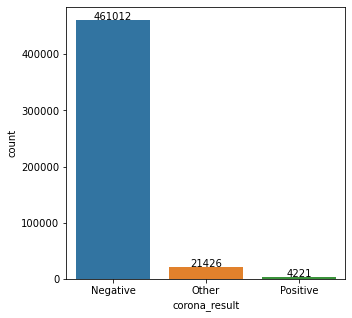

In [13]:
plt.figure(figsize=(5,5))
corona_result = sns.countplot(df['corona_result'],label="Count")

for p in corona_result.patches:
    height = p.get_height()
    corona_result.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

The class lable is highly imbalanced. The proportion of positive instances is less than **1%**. We need to be cautious about this.

**BreakDown of feature distribution**

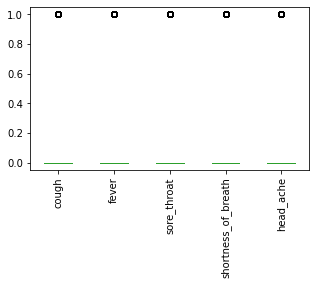

In [14]:
df.plot.box(figsize=(5, 3)) # visualize the feature distribution
plt.xticks(rotation='vertical');
# the value distribution of 5 numeric features are highly skewed with over 75% being 0.

**BreakDown of cough**

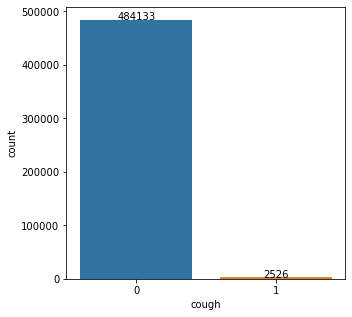

In [15]:
plt.figure(figsize=(5,5))
cough = sns.countplot(data=df, x="cough")

for p in cough.patches:
    height = p.get_height()
    cough.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

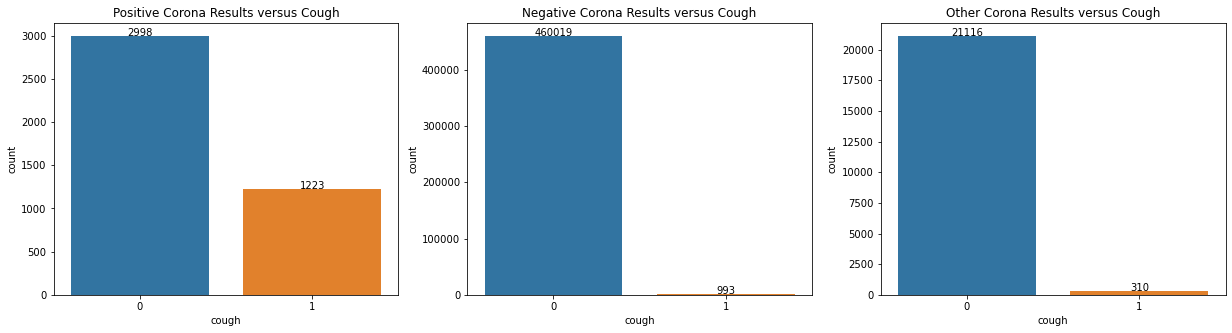

In [16]:
f, axes = plt.subplots(1, 3, figsize=(21,5))
positive = sns.countplot(df[df['corona_result'] == 'Positive']["cough"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus Cough")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["cough"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus Cough')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["cough"], ax=axes[2])
axes[2].set_title('Other Corona Results versus Cough')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of fever**

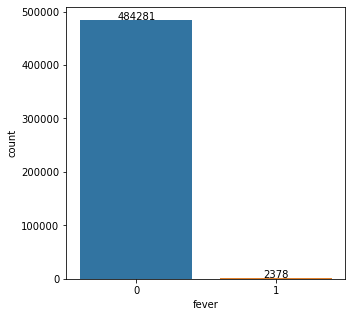

In [17]:
plt.figure(figsize=(5,5))
fever = sns.countplot(data=df, x="fever")

for p in fever.patches:
    height = p.get_height()
    fever.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

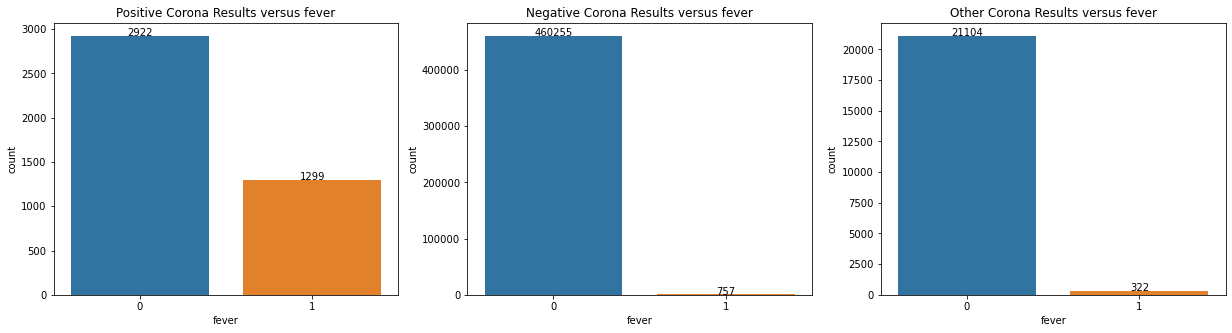

In [18]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["fever"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus fever")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["fever"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus fever')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["fever"], ax=axes[2])
axes[2].set_title('Other Corona Results versus fever')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of sore_throat**

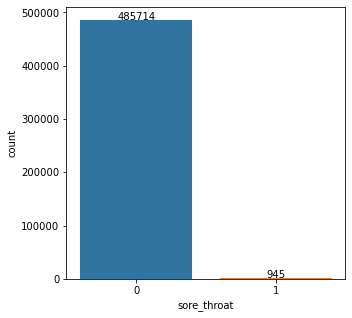

In [19]:
plt.figure(figsize=(5,5))
sore_throat = sns.countplot(data=df, x="sore_throat")

for p in sore_throat.patches:
    height = p.get_height()
    sore_throat.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")



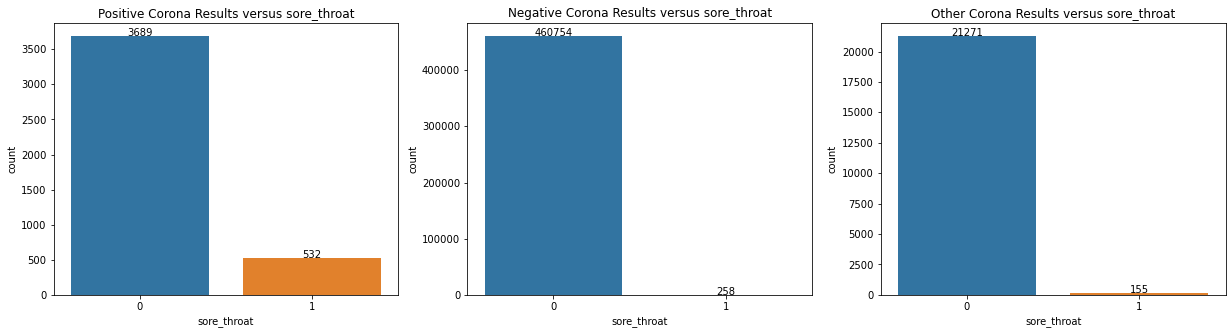

In [20]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["sore_throat"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus sore_throat")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["sore_throat"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus sore_throat')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["sore_throat"], ax=axes[2])
axes[2].set_title('Other Corona Results versus sore_throat')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of shortness_of_breath**

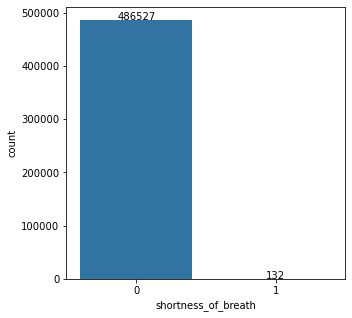

In [21]:
plt.figure(figsize=(5,5))
shortness_of_breath = sns.countplot(data=df, x="shortness_of_breath")

for p in shortness_of_breath.patches:
    height = p.get_height()
    shortness_of_breath.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

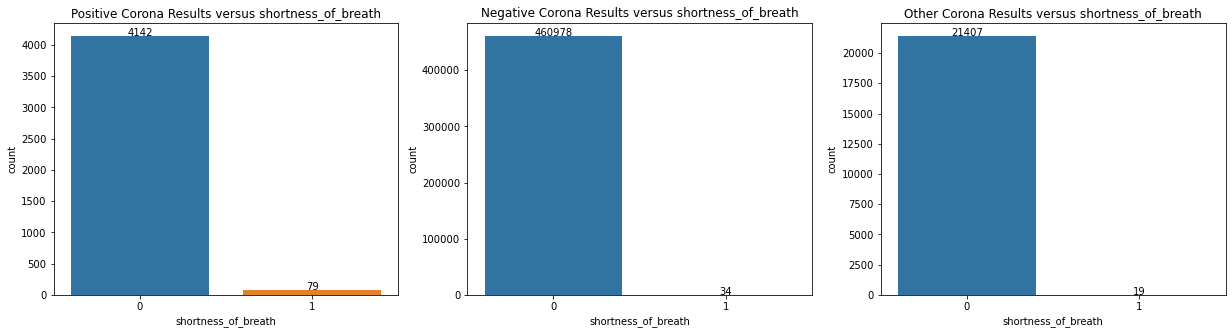

In [22]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["shortness_of_breath"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus shortness_of_breath")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["shortness_of_breath"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus shortness_of_breath')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["shortness_of_breath"], ax=axes[2])
axes[2].set_title('Other Corona Results versus shortness_of_breath')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()


**BreakDown of head_ache**

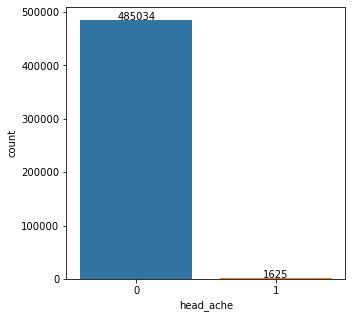

In [23]:
plt.figure(figsize=(5,5))
head_ache = sns.countplot(data=df, x="head_ache")

for p in head_ache.patches:
    height = p.get_height()
    head_ache.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")
plt.show()

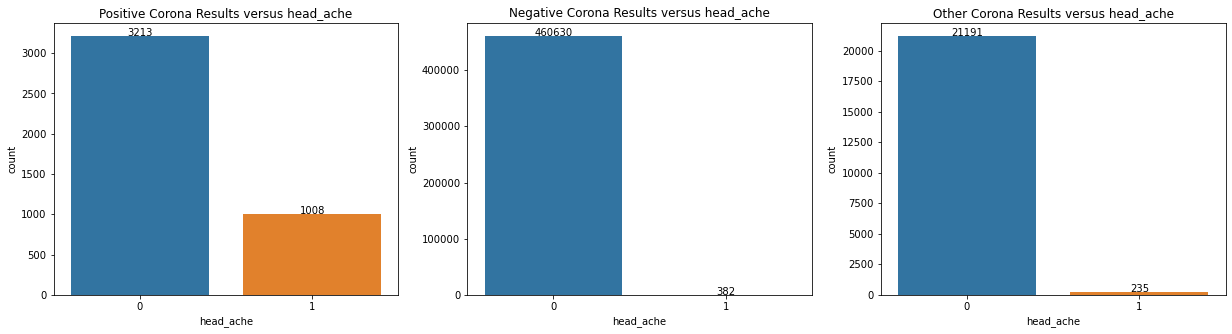

In [24]:
f, axes = plt.subplots(1, 3, figsize=(21,5))

positive = sns.countplot(df[df['corona_result'] == 'Positive']["head_ache"], ax=axes[0]) 
axes[0].set_title("Positive Corona Results versus head_ache")
for p in positive.patches:
    height = p.get_height()
    positive.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

# we don't need kernel desity estimate because the feature is discrete.
negative = sns.countplot(df[df['corona_result'] == 'Negative']["head_ache"], ax=axes[1])
axes[1].set_title('Negative Corona Results versus head_ache')
for p in negative.patches:
    height = p.get_height()
    negative.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

other = sns.countplot(df[df['corona_result'] == 'Other']["head_ache"], ax=axes[2])
axes[2].set_title('Other Corona Results versus head_ache')
for p in other.patches:
    height = p.get_height()
    other.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

plt.show()

**Corona Result along with time**

In [25]:
matplotlib.style.use('seaborn-white')

In [26]:
df

,date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age,gender,test_indication
0,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
1,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
2,2021-07-25,1,1,1,0,1,Other,No,Female,Abroad
3,2021-07-25,0,0,0,0,0,Negative,No,Male,Other
4,2021-07-25,0,0,0,0,0,Negative,No,Female,Other
...,...,...,...,...,...,...,...,...,...,...
486654,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486655,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486656,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other
486657,2021-05-31,0,0,0,0,0,Negative,NaN,NaN,Other


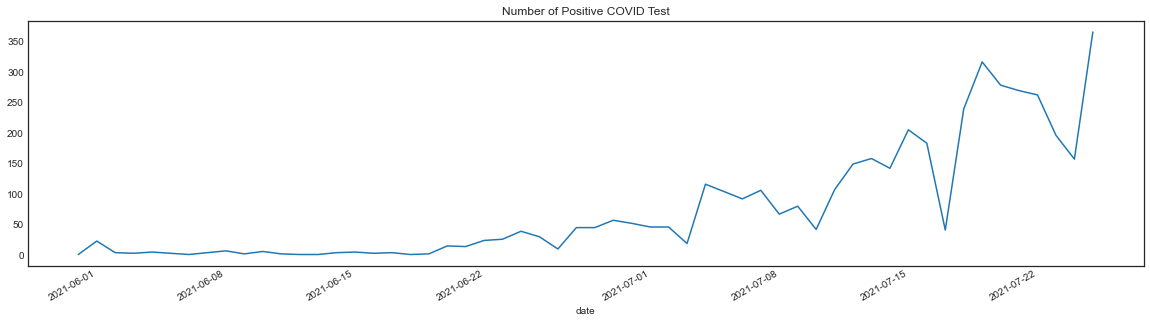

In [27]:
df[df['corona_result'] == "Positive"].groupby('date').size().plot(figsize=(20, 5), title="Number of Positive COVID Test");

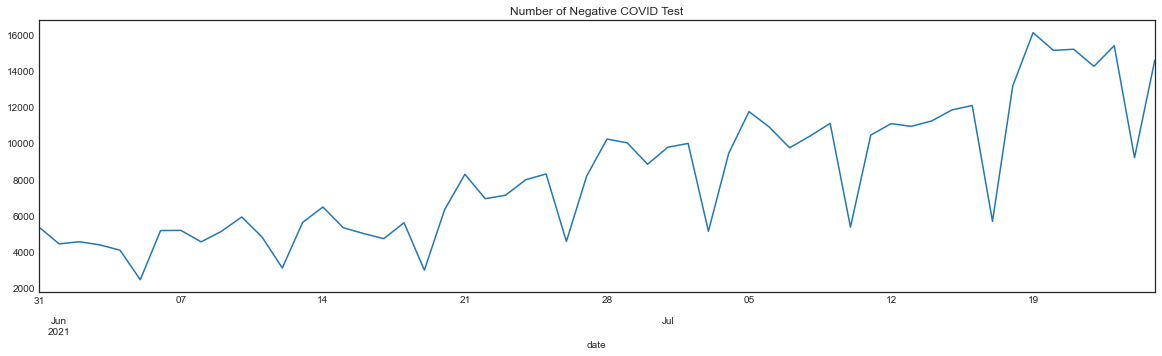

In [28]:
df[df['corona_result'] == "Negative"].groupby('date').size().plot(figsize=(20, 5), title="Number of Negative COVID Test");

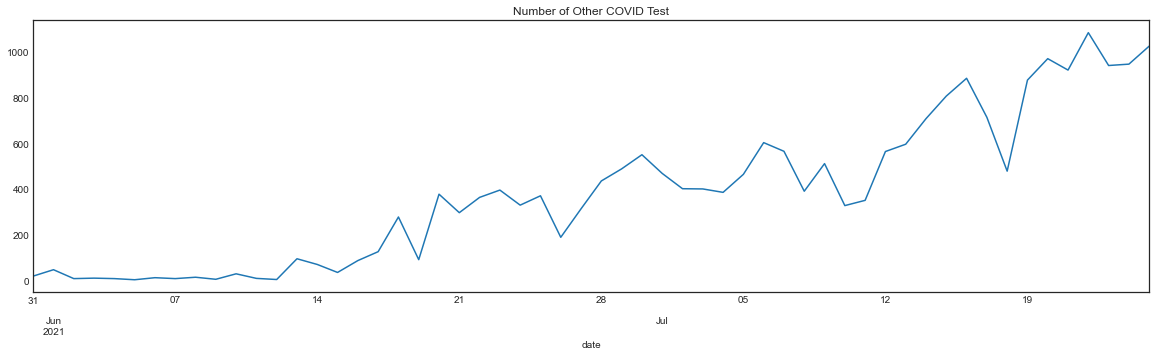

In [29]:
df[df['corona_result'] == "Other"].groupby('date').size().plot(figsize=(20, 5), title="Number of Other COVID Test");

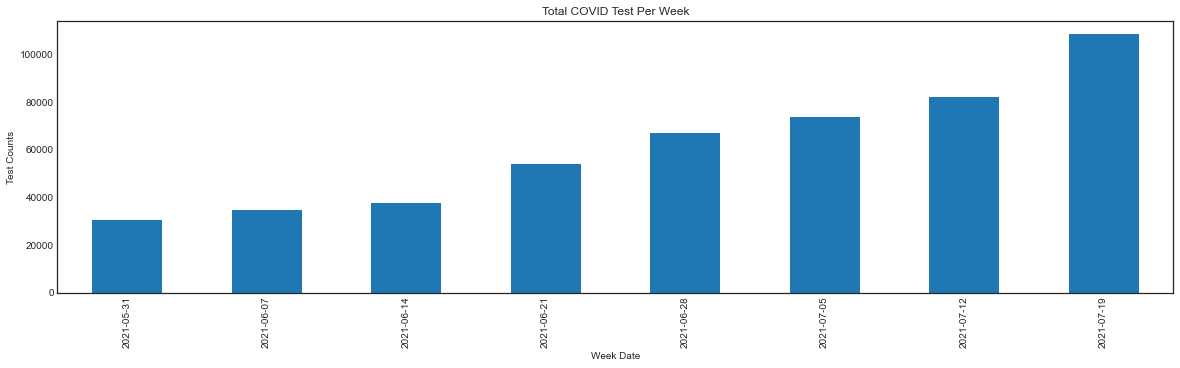

In [30]:
import pandas as pd, datetime as dt

df_weekly = pd.DataFrame(df.apply(lambda row: row['date'] - dt.timedelta(days=row['date'].weekday()), axis=1), columns = ['WeekDate'])
df_weekly['WeekDate'] = pd.to_datetime(df_weekly['WeekDate']).dt.date

perweek = df_weekly['WeekDate'].groupby(df_weekly['WeekDate']).count()
perweek.plot(kind="bar", figsize=(20, 5));
plt.title("Total COVID Test Per Week")
plt.xlabel("Week Date")
plt.ylabel("Test Counts")
plt.show()

Combining what we have analyzed above, the volume of test cases varies week by week but is generally trending upwards.

## 4 Data Preprocessing

**Remove the instances with results of *Others* (not tested, testing)**

In [31]:
df = df[df['corona_result'] != 'Other']
df = df.drop("date", axis = 1)

### Imputation

In [32]:
# How many features have missing values?
n_missing = len(df.columns[df.isnull().any()])
"{} features have missing values.".format(n_missing)

'2 features have missing values.'

In [33]:
keys = ['Total', 'Percent']

null_total = df.isnull().sum().sort_values(ascending=False)
null_percent = (df.isnull().sum() /df.isnull().count())

df_missing = pd.concat([null_total, null_percent], axis=1, keys=keys, sort=False)
df_missing = df_missing.sort_values(by='Percent', ascending=False)
df_missing.head(n_missing)

,Total,Percent
age,275466,0.592103
gender,208245,0.447614


The percentage of the missing values is large. We will test on filled and dropped datasets and see if one improves the accuracy

In [34]:
# replace the missing value
X_filled = df.copy().drop("corona_result", axis = 1)
y_filled = df.copy()["corona_result"]
X_filled_nom = X_filled.select_dtypes(include=[object])
X_filled_num = X_filled.select_dtypes(include=[np.number])

X_filled[X_filled_nom.columns] = X_filled_nom.fillna('Missing')
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,test_indication
0,0,0,0,0,0,No,Female,Other
1,0,0,0,0,0,No,Female,Other
3,0,0,0,0,0,No,Male,Other
4,0,0,0,0,0,No,Female,Other
5,0,0,0,0,0,No,Missing,Other


In [35]:
# drop the rows with missing value
df_dropped = df.dropna(how = 'any', axis=0)
X_dropped = df_dropped.drop("corona_result", axis = 1)
y_dropped = df_dropped["corona_result"]

In [36]:
n_missing = len(X_dropped.columns[X_dropped.isnull().any()])
"{} features have missing values.".format(n_missing)

'0 features have missing values.'

### Encoding

In [37]:
X_filled_nom_trans = pd.get_dummies(X_filled[X_filled_nom.columns])

In [38]:
X_filled = pd.concat([X_filled_num, X_filled_nom_trans], axis = 1)

In [39]:
X_filled.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_Missing,age_No,age_Yes,gender_Female,gender_Male,gender_Missing,test_indication_Abroad,test_indication_Contact with confirmed,test_indication_Other
0,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1,0,0,0,1
4,0,0,0,0,0,0,1,0,1,0,0,0,0,1
5,0,0,0,0,0,0,1,0,0,0,1,0,0,1


**When dropping the missing value, the two nominal features (gender and age) are all binary feature. Thus we can encode these features as 0 and 1**

In [40]:
# gender and age features are binary so use labelEncoder to be consistent with the syndrome features (binary)
le = LabelEncoder()
le.fit(X_dropped["gender"])
X_dropped["gender"] = le.transform(X_dropped["gender"])
le.fit(X_dropped["age"])
X_dropped["age"] = le.transform(X_dropped["age"])
# X_indication have multi variable so use get dummies instead. OneHotEncoder can't convert df with some string
X_indication = pd.get_dummies(X_dropped["test_indication"])
X_dropped = pd.concat([X_dropped.drop("test_indication", axis=1), X_indication], axis=1)

In [41]:
X_dropped.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age,gender,Abroad,Contact with confirmed,Other
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,1,0,0,1


**Encoding the class label value**

In [42]:
le.fit(y_dropped)
y_dropped = le.transform(y_dropped)
le.fit(y_filled)
y_filled = le.transform(y_filled)

## 5. Feature selection

https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
https://www.kaggle.com/prashant111/comprehensive-guide-on-feature-selection

Conclusion drawn from the above article:
SelectKBest with Fisher Score
Recursive Feature Elimination with Cross-Validation (RFECV)
Correlation-matrix with heatmap
Random-Forest Importance

### 5.1 Performance metrics tailored for imbalanced data

https://imbalanced-learn.org/stable/references/metrics.html#module-imblearn.metrics

In [43]:
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import sensitivity_specificity_support
from imblearn.metrics import sensitivity_score
from imblearn.metrics import specificity_score
from imblearn.metrics import geometric_mean_score
from imblearn.metrics import classification_report_imbalanced
from imblearn.metrics import macro_averaged_mean_absolute_error

In [44]:
def evaluate_imbalanced(y_test, y_pred):
    output = dict()
    output["Balanced Accuracy"] = balanced_accuracy_score(y_test, y_pred)
    output["Sensitivity"] = sensitivity_score(y_test, y_pred, average='weighted') ## high indicates low false negative
    output["Specificity"] = specificity_score(y_test, y_pred, average='weighted') ## high indicates low false positive
    output["AUROC"] = roc_auc_score(y_test, y_pred) ##TPR
    output["F1"] = f1_score(y_test, y_pred, average="binary") ##weighted precision and recall (both positive dominated)
    output["Geometric Mean"] = geometric_mean_score(y_test, y_pred, average='weighted') ## class-wise sensitivity
    output["Macro Average MAE"] = macro_averaged_mean_absolute_error(y_test, y_pred)
    return output

1. The sensitivity is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The sensitivity quantifies the ability to avoid false negatives. The best value is 1 and the worst value is 0.

2. 'weighted':
Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

3. The specificity is the ratio tn / (tn + fp) where tn is the number of true negatives and fp the number of false positives. The specificity quantifies the ability to avoid false positives. The best value is 1 and the worst value is 0.

4. The geometric mean (G-mean) is the root of the product of class-wise sensitivity. 

5. This function computes each MAE for each class and average them, giving an equal weight to each class.

### 5.2 Original performance without feature selection

In [45]:
# prepare a df to store the results from each method
# TO DO: random_state, most cases are 42 or 43 why?
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)


In [46]:
#random forest classifier with n_estimators=10 (default) tree-based model is well-suited for imbalanced data
def make_y_pred(x_train, x_test, y_train):
    model_ori = RandomForestClassifier(random_state=43)      
    model_ori = model_ori.fit(x_train,y_train)
    y_pred = model_ori.predict(x_test)
    return y_pred

In [47]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [48]:
results_ori = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'Original'])
results_ori

,Method,Original
0,Balanced Accuracy,0.824516
1,Sensitivity,0.994691
2,Specificity,0.654340
3,AUROC,0.824516
4,F1,0.684547
5,Geometric Mean,0.806763
6,Macro Average MAE,0.175484


In [49]:
def make_confusion_matrix(y_test,y_pred):
    cf_matrix = confusion_matrix(y_test,y_pred)
    fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Greens', linewidths=.1, ax=ax);
    ax.set_title('Confusion Matrix');

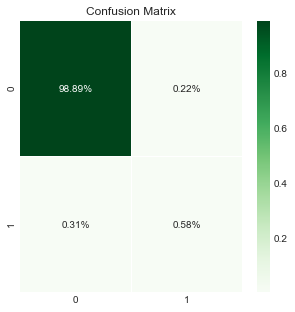

In [50]:
make_confusion_matrix(y_test,y_pred)

## 5.3.1 Feature selection--Filter method

**1. Mutual Info between features and class label (drop date column for now)**

In [51]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

In [52]:
mi_reg = mutual_info_regression(X_filled, y_filled)
mi_cla = mutual_info_classif(X_filled, y_filled)

In [53]:
df_mi = pd.DataFrame(mi_reg, index=X_filled.columns, columns=['mutual_info_reg'])

In [54]:
def highlight_top6(s):
    """Highlight the maximum in a Series green."""
    is_large = s.nlargest(6).values
    return ['background-color: green' if v in is_large else '' for v in s ]

In [55]:
# top 6 are highlighted
df_mi.sort_values("mutual_info_reg", ascending=False).style.apply(highlight_top6)

,mutual_info_reg
test_indication_Contact with confirmed,0.016277
test_indication_Other,0.016214
fever,0.011105
head_ache,0.008253
cough,0.008175
sore_throat,0.003738
age_Missing,0.002993
gender_Male,0.002069
gender_Missing,0.001693
shortness_of_breath,0.001474


**Most features are nearly independent. No feature filtered out with this method**

In [56]:
# for scoring only, need to combine with other methods
from sklearn.feature_selection import f_regression, f_classif
f_reg = f_regression(X_filled, y_filled)
f_clasif = f_classif(X_filled, y_filled)

**2. Correlation matrix with heatmap for features in X_filled (missing values filled)**

In [57]:
# corr for mean
corr1 = X_filled.corr();
corr2 = X_dropped.corr();

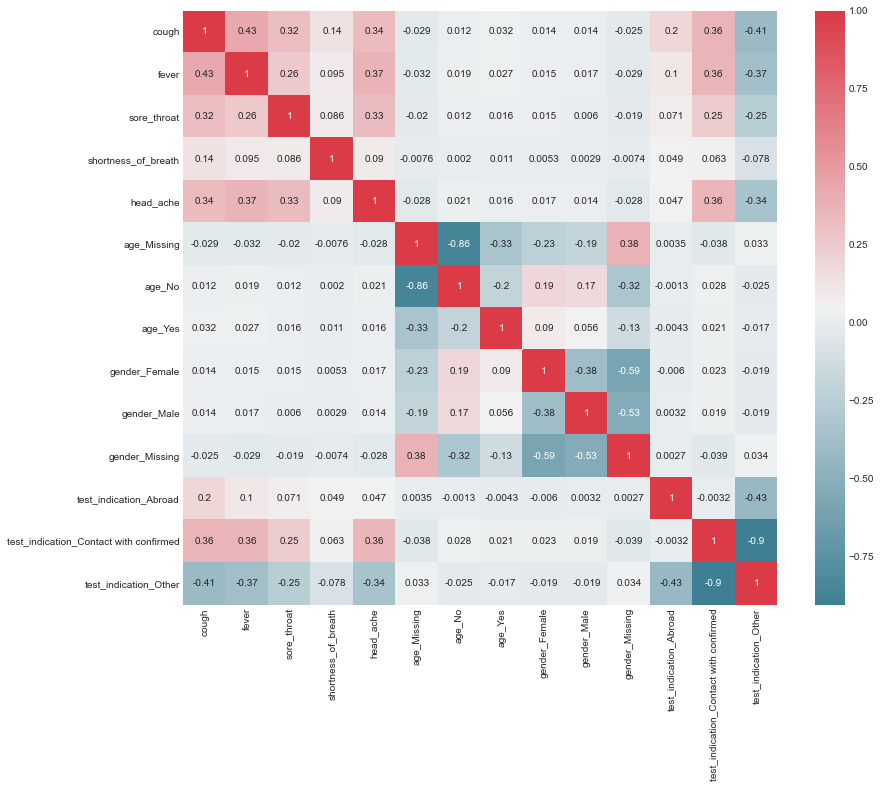

In [58]:
plt.rc("figure", figsize=(15, 15))
grid=sns.heatmap(corr1,annot=True,cbar = True, square = True, cmap=sns.diverging_palette(220, 10, as_cmap=True))
grid.set_xticklabels(corr1.columns,rotation=90)
plt.subplots_adjust(left=0.3,right=1,bottom=0.35,top=0.9)
plt.show()

**Findings: The correlations between any two features are low. No correlation is higher than 0.9. No feature filtered out with this method**

In [59]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [60]:
# # refresher
x_train, x_test, y_train, y_test = train_test_split(X_filled, y_filled, test_size=0.2, random_state=0)

In [61]:
# find best scored 5 features
selector = SelectKBest(chi2, k=5)
select_feature = selector.fit(x_train, y_train)
df_chi2 = pd.DataFrame(select_feature.scores_, index=x_train.columns, columns=['SelectKBest-chi2'])
df_chi2.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,SelectKBest-chi2
test_indication_Contact with confirmed,97792.214762
fever,70120.384480
head_ache,62286.259488
cough,56200.021071
sore_throat,30008.323534
shortness_of_breath,4462.521708
age_Yes,754.507236
test_indication_Other,710.261205
gender_Missing,661.563719
age_Missing,598.631176


In [62]:
# side-by-side comparison with mi
merged = df_chi2.join(df_mi)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,SelectKBest-chi2,mutual_info_reg
test_indication_Contact with confirmed,97792.214762,0.016277
fever,70120.384480,0.011105
head_ache,62286.259488,0.008253
cough,56200.021071,0.008175
sore_throat,30008.323534,0.003738
shortness_of_breath,4462.521708,0.001474
age_Yes,754.507236,0.000206
test_indication_Other,710.261205,0.016214
gender_Missing,661.563719,0.001693
age_Missing,598.631176,0.002993


In [63]:
x_train_2 = select_feature.transform(x_train)
x_test_2 = select_feature.transform(x_test)

y_pred = make_y_pred(x_train_2, x_test_2, y_train)

In [64]:
results_select = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=[ 'Method', 'SelectedKBest-chi2'])
results_select

,Method,SelectedKBest-chi2
0,Balanced Accuracy,0.831920
1,Sensitivity,0.993853
2,Specificity,0.669988
3,AUROC,0.831920
4,F1,0.657485
5,Geometric Mean,0.816008
6,Macro Average MAE,0.168080


In [65]:
results = results_ori.set_index('Method').join(results_select.set_index('Method'))
results['%'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results

,Original,SelectedKBest-chi2,%
Method,,,
Balanced Accuracy,0.824516,0.831920,0.9%
Sensitivity,0.994691,0.993853,-0.08%
Specificity,0.654340,0.669988,2.39%
AUROC,0.824516,0.831920,0.9%
F1,0.684547,0.657485,-3.95%
Geometric Mean,0.806763,0.816008,1.15%
Macro Average MAE,0.175484,0.168080,-4.22%


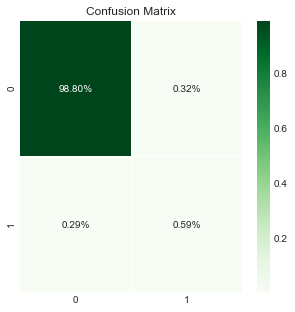

In [66]:
make_confusion_matrix(y_test,y_pred)

### 5.3.2 Feature selection--Wrapper method

**Recursive feature elimination (RFE) with random forest**

In [67]:
from sklearn.feature_selection import RFE
# Create the RFE object and rank each pixel
# using the same classifer as original 
model_ori = RandomForestClassifier(random_state=43)
rfe = RFE(estimator=model_ori, n_features_to_select=6, step=1)
rfe = rfe.fit(x_train, y_train)

In [68]:
df_rfe = pd.DataFrame(rfe.support_, index=x_train.columns, columns=['RFE'])
df_rfe.sort_values('RFE', ascending=False).style.apply(highlight_top6)

,RFE
cough,True
fever,True
sore_throat,True
head_ache,True
test_indication_Contact with confirmed,True
test_indication_Other,True
shortness_of_breath,False
age_Missing,False
age_No,False
age_Yes,False


In [69]:
merged = df_mi.join(df_chi2.join(df_rfe))
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,mutual_info_reg,SelectKBest-chi2,RFE
test_indication_Contact with confirmed,0.016277,97792.214762,True
fever,0.011105,70120.384480,True
head_ache,0.008253,62286.259488,True
cough,0.008175,56200.021071,True
sore_throat,0.003738,30008.323534,True
shortness_of_breath,0.001474,4462.521708,False
age_Yes,0.000206,754.507236,False
test_indication_Other,0.016214,710.261205,True
gender_Missing,0.001693,661.563719,False
age_Missing,0.002993,598.631176,False


**Findings: align mostly with SelectedKBest and the same as MI**

In [70]:
# TO DO:
# Why MI and RFE have test_indication_other

**Recursive feature elimination with cross validation and random forest classification**

In [71]:
from sklearn.feature_selection import RFECV

# using the same classifer as original 
rfecv = RFECV(estimator=model_ori, step=1, cv=5,scoring='f1')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)

In [72]:
df_RFECV = pd.DataFrame(rfecv.n_features_, index=x_train.columns, columns=['RFECV'])
df_RFECV.sort_values('RFECV', ascending=False).style.apply(highlight_top6)

,RFECV
cough,6
fever,6
sore_throat,6
shortness_of_breath,6
head_ache,6
age_Missing,6
age_No,6
age_Yes,6
gender_Female,6
gender_Male,6


grid_scores_ : array of shape [n_subsets_of_features]
The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.

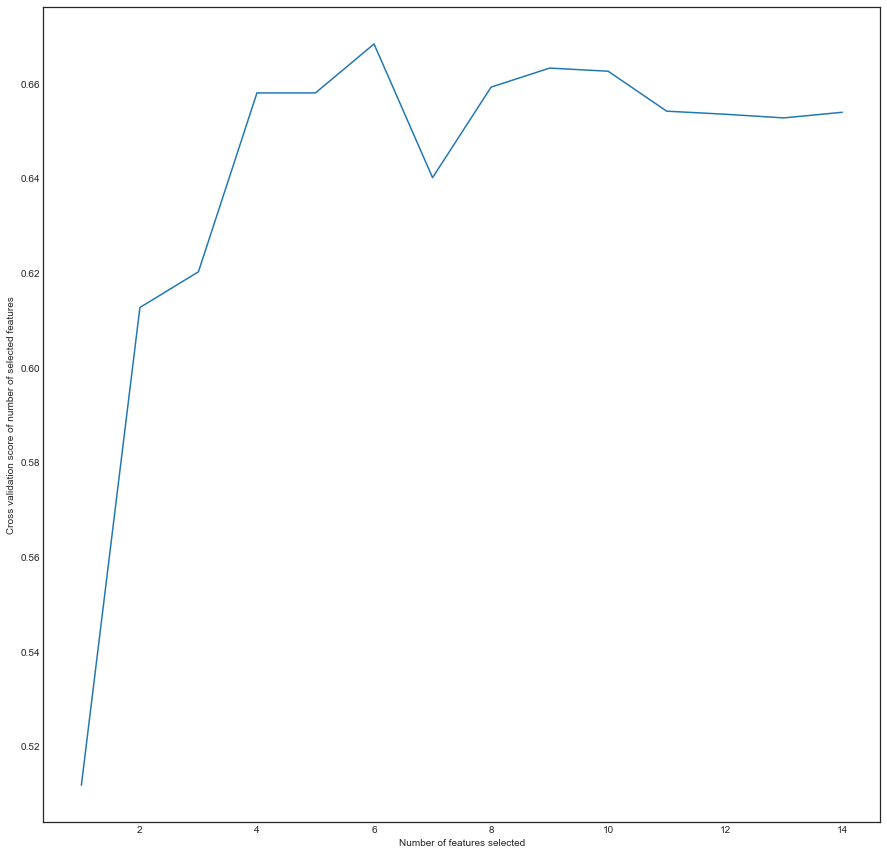

In [73]:
# Plot number of features VS. cross-validation scores
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

**Findings: we can observe the validation score peaks at 8 features**

### 5.3.3 Feature Selection - Embedded Methods

**Random Forest Importance**

In [74]:
clf_rf_5 = RandomForestClassifier()      
clr_rf_5 = clf_rf_5.fit(x_train,y_train)
importances = clr_rf_5.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_5.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [75]:
df_RF_importance = pd.DataFrame(clr_rf_5.feature_importances_, index=x_train.columns, columns=['RF_importance'])
df_RF_importance.sort_values('RF_importance', ascending=False).style.apply(highlight_top6)

,RF_importance
test_indication_Contact with confirmed,0.211744
fever,0.185490
test_indication_Other,0.181899
head_ache,0.141699
cough,0.119660
sore_throat,0.054607
test_indication_Abroad,0.024789
age_Missing,0.020187
gender_Missing,0.015581
age_Yes,0.012047


In [76]:
merged = merged.join(df_RF_importance)
merged.sort_values('SelectKBest-chi2', ascending=False).style.apply(highlight_top6)

,mutual_info_reg,SelectKBest-chi2,RFE,RF_importance
test_indication_Contact with confirmed,0.016277,97792.214762,True,0.211744
fever,0.011105,70120.384480,True,0.185490
head_ache,0.008253,62286.259488,True,0.141699
cough,0.008175,56200.021071,True,0.119660
sore_throat,0.003738,30008.323534,True,0.054607
shortness_of_breath,0.001474,4462.521708,False,0.010117
age_Yes,0.000206,754.507236,False,0.012047
test_indication_Other,0.016214,710.261205,True,0.181899
gender_Missing,0.001693,661.563719,False,0.015581
age_Missing,0.002993,598.631176,False,0.020187


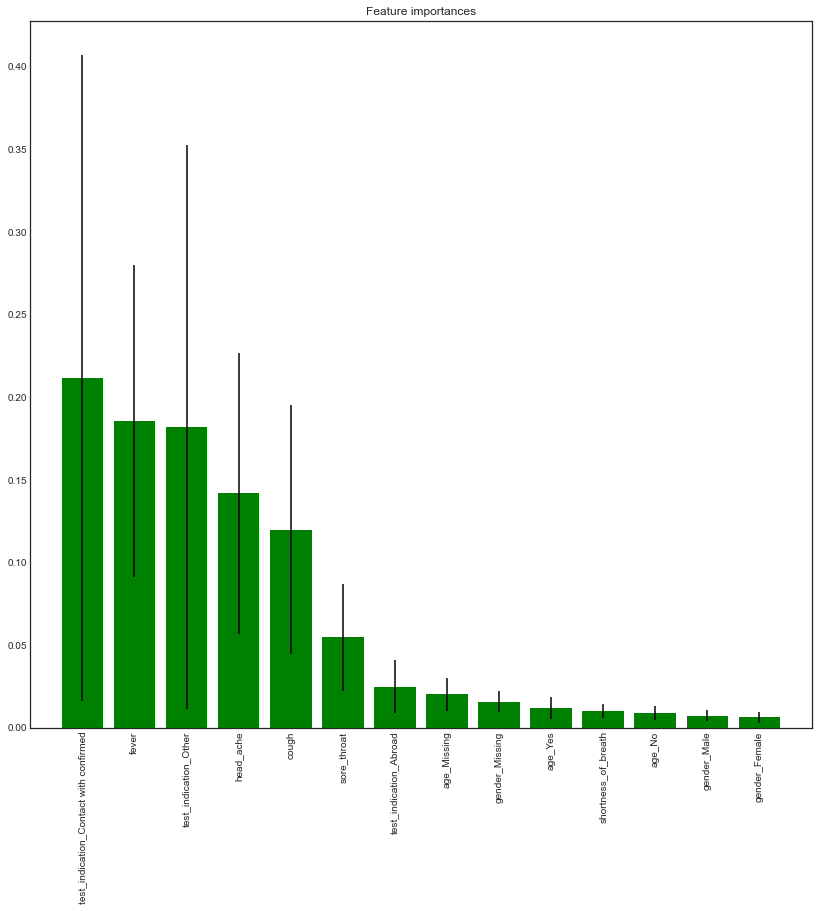

In [77]:
#  to determine how many should be selected

# Plot the feature importances of the forest
plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
     color="g", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices],rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.show()

**Feature Extraction with PCA**

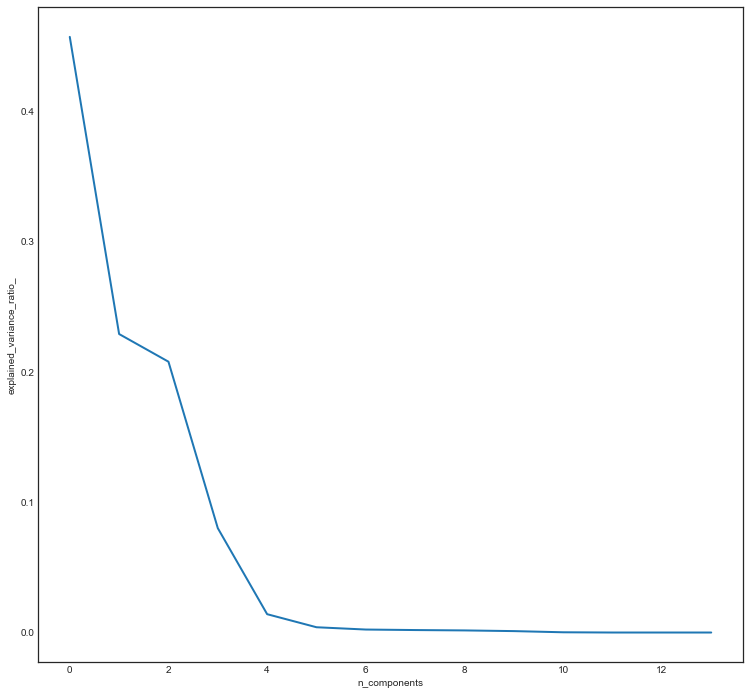

In [78]:
#  to determine how many should be selected
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)

plt.figure(1, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_');

6 features are definitely enough

**Conclusion: We believe it's safe to select the top 6 features: 
'test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','shortness_of_breath'

### 5.4.1 6-feature selection method comparison

In [79]:
#prepare the selected dataset with the 6th being test_indication_Other
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','test_indication_Other']
# X_selected = X_filled.drop("corona_result", axis = 1)
X_selected = X_filled[X_filled.columns[X_filled.columns.isin(selected_columns)]]

In [80]:
# update the train and test split
x_train, x_test, y_train, y_test = train_test_split(X_selected, y_filled, test_size=0.2, random_state=0)

In [81]:
y_pred = make_y_pred(x_train, x_test, y_train)

In [82]:
results_other = pd.DataFrame(evaluate_imbalanced(y_test, y_pred).items(),columns=['Method', 'All other 3 methods'])
results_other

,Method,All other 3 methods
0,Balanced Accuracy,0.855055
1,Sensitivity,0.994358
2,Specificity,0.715753
3,AUROC,0.855055
4,F1,0.690995
5,Geometric Mean,0.843632
6,Macro Average MAE,0.144945


In [83]:
# results = results.set_index('Method').join(results_other.set_index('Method'))
results = results_ori.set_index('Method').join(results_select.set_index('Method')).join(results_other.set_index('Method'))
results['original vs other 3 %'] = (((results['All other 3 methods'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'
results['original vs sel-chi2 %'] = (((results['SelectedKBest-chi2'] - results['Original']) / results['Original'])*100 ).round(2).astype(str) + '%'

results

,Original,SelectedKBest-chi2,All other 3 methods,original vs other 3 %,original vs sel-chi2 %
Method,,,,,
Balanced Accuracy,0.824516,0.831920,0.855055,3.7%,0.9%
Sensitivity,0.994691,0.993853,0.994358,-0.03%,-0.08%
Specificity,0.654340,0.669988,0.715753,9.39%,2.39%
AUROC,0.824516,0.831920,0.855055,3.7%,0.9%
F1,0.684547,0.657485,0.690995,0.94%,-3.95%
Geometric Mean,0.806763,0.816008,0.843632,4.57%,1.15%
Macro Average MAE,0.175484,0.168080,0.144945,-17.4%,-4.22%


** The above comparison shows that selecting 6 features including test_indication_Other improves the performance more than selectKBest-chi2. 
<!-- test_indication_other has a positive effect on the performance metrics. We decide to add it as the seventh feature** -->

### 5.4.2 dropped or filled comparison

In [84]:
#prepare the selected dataset with the 6th being test_indication_Other
selected_columns = ['test_indication_Contact with confirmed', 'head_ache', 'fever', 'cough','sore_throat','test_indication_Other']
# X_selected = X_filled.drop("corona_result", axis = 1)
X_selected_dropped = X_dropped[X_dropped.columns[X_dropped.columns.isin(selected_columns)]]

In [85]:
# update the train and test split
x_train_d, x_test_d, y_train_d, y_test_d = train_test_split(X_selected_dropped, y_dropped, test_size=0.2, random_state=0)

In [86]:
y_pred_d = make_y_pred(x_train_d, x_test_d, y_train_d)

In [87]:
results_other_dropped = pd.DataFrame(evaluate_imbalanced(y_test_d, y_pred_d).items(),columns=['Method', 'All other 3 methods'])
results_other_dropped

,Method,All other 3 methods
0,Balanced Accuracy,0.784831
1,Sensitivity,0.988189
2,Specificity,0.581473
3,AUROC,0.784831
4,F1,0.637591
5,Geometric Mean,0.758027
6,Macro Average MAE,0.215169


In [88]:
results

,Original,SelectedKBest-chi2,All other 3 methods,original vs other 3 %,original vs sel-chi2 %
Method,,,,,
Balanced Accuracy,0.824516,0.831920,0.855055,3.7%,0.9%
Sensitivity,0.994691,0.993853,0.994358,-0.03%,-0.08%
Specificity,0.654340,0.669988,0.715753,9.39%,2.39%
AUROC,0.824516,0.831920,0.855055,3.7%,0.9%
F1,0.684547,0.657485,0.690995,0.94%,-3.95%
Geometric Mean,0.806763,0.816008,0.843632,4.57%,1.15%
Macro Average MAE,0.175484,0.168080,0.144945,-17.4%,-4.22%


In [89]:
results_d = results_other.merge(results_other_dropped, on='Method', how='left')
results_d.columns=['Method','All other 3 methods_filled','All other 3 methods_dropped'] 
results_d['dropped vs filled'] = (((results_d['All other 3 methods_dropped'] - results_d['All other 3 methods_filled']) / results_d['All other 3 methods_filled'])*100 ).round(2).astype(str) + '%'
results_d

,Method,All other 3 methods_filled,All other 3 methods_dropped,dropped vs filled
0,Balanced Accuracy,0.855055,0.784831,-8.21%
1,Sensitivity,0.994358,0.988189,-0.62%
2,Specificity,0.715753,0.581473,-18.76%
3,AUROC,0.855055,0.784831,-8.21%
4,F1,0.690995,0.637591,-7.73%
5,Geometric Mean,0.843632,0.758027,-10.15%
6,Macro Average MAE,0.144945,0.215169,48.45%


Conclusion: dropping instances with null values in age or gender feature does not improve the performance.

## Imbalanced sampling

https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling

pip install imbalanced-learn

In [92]:
X = X_selected.copy()
Y = y_filled.copy()
print(X.shape)
print(Y.shape)

(465233, 6)
(465233,)


**Oversampling: Naive Random Over-Sampling (ROS) to increase the sample size of under-represented data by replication with replacement**

In [93]:
from imblearn.over_sampling import RandomOverSampler
def oversample(X, Y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, Y)

**Oversampling:SMOTE based on KNN and generating new samples**

In [94]:
from imblearn.over_sampling import SMOTE
def oversample_smote(X, Y):
    return SMOTE().fit_resample(X, Y)

**Under-sampling:Random Under-Sampler (RUS) is a fast and easy way to balance the data by randomly selecting a subset of data for the targeted classes**

In [95]:
from imblearn.under_sampling import RandomUnderSampler
def undersample(X, Y):
    rus = RandomUnderSampler(random_state=0)
    return rus.fit_resample(X, Y)

## Modeling

**the paramter of all classifier are tested and determined to be optimal by prior demos.**

In [100]:
models = {
    "Dummy Classifier" : DummyClassifier(strategy='uniform'), # dummy classifier to predict randomly
    "Most Frequent Clasifier" : DummyClassifier(strategy='most_frequent'), # dummy classifier to always predict the majority
    "Perceptron": Perceptron(alpha = 0.1),
    "Decision Tree (max_depth=None)": DecisionTreeClassifier(max_depth=None, random_state=0),
    "GNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(random_state=0, n_estimators = 101),
    "GradientBoostingForest": GradientBoostingClassifier(random_state=0, n_estimators = 101),
    "XGBoost": XGBClassifier(n_estimators=1000, tree_method='hist', random_state=0, eval_metric='mlogloss')
}

**Apply Neural Netword model to the dataset**

In [104]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import roc_curve
from numpy import sqrt
from numpy import argmax
# define the keras model
nmodel = Sequential()
# add layers
nmodel.add(Dense(12, input_dim=6, activation='relu'))
nmodel.add(Dense(6, activation='relu'))
nmodel.add(Dense(1, activation='sigmoid'))
nmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy', 'AUC'])
models['Neural Network'] = nmodel

In [105]:
def thresholding(pred, y): # threasholding the continuous predicted value to binary labels
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y, pred)
    # use gemans to select the optimal threshold
    gmeans = sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = argmax(gmeans)
    threshold = thresholds[ix]
    for i in range(len(y)):
        pred[i] = 1 if pred[i] >= threshold else 0
    return pred

### original sampling

In [106]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

13085/13085 [==============================] - 9s 660us/step - loss: 0.0228 - binary_accuracy: 0.9938 - auc: 0.8788


In [107]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [108]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
GNB,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
Neural Network,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
Decision Tree (max_depth=None),0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
RandomForest,0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
XGBoost,0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
GradientBoostingForest,0.837085,0.993719,0.680451,0.837085,0.661969,0.822250,0.162915
Perceptron,0.624147,0.991983,0.256311,0.624147,0.323432,0.456407,0.375853
Dummy Classifier,0.510758,0.500734,0.520782,0.510758,0.018583,0.510554,0.489242
Most Frequent Clasifier,0.500000,0.990927,0.009073,0.500000,0.000000,0.094819,0.500000


In [109]:
results_train = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
GNB,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
Neural Network,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
Decision Tree (max_depth=None),0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
RandomForest,0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
XGBoost,0.846892,0.993848,0.699935,0.846892,0.672924,0.833985,0.153108
GradientBoostingForest,0.837085,0.993719,0.680451,0.837085,0.661969,0.822250,0.162915
Perceptron,0.624147,0.991983,0.256311,0.624147,0.323432,0.456407,0.375853
Dummy Classifier,0.510758,0.500734,0.520782,0.510758,0.018583,0.510554,0.489242
Most Frequent Clasifier,0.500000,0.990927,0.009073,0.500000,0.000000,0.094819,0.500000


### over sampling

In [110]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = oversample(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

25932/25932 [==============================] - 16s 622us/step - loss: 0.3173 - binary_accuracy: 0.8782 - auc: 0.8788


In [111]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [112]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Neural Network,0.876350,0.992911,0.759788,0.876350,0.660111,0.868504,0.123650
GradientBoostingForest,0.876205,0.992625,0.759785,0.876205,0.651057,0.868377,0.123795
GNB,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
XGBoost,0.875883,0.992685,0.759082,0.875883,0.652677,0.868000,0.124117
Decision Tree (max_depth=None),0.875882,0.992683,0.759082,0.875882,0.652609,0.867999,0.124118
RandomForest,0.875882,0.992683,0.759082,0.875882,0.652610,0.867999,0.124118
Perceptron,0.872702,0.992662,0.752742,0.872702,0.650019,0.864267,0.127298
Dummy Classifier,0.501012,0.500721,0.501303,0.501012,0.017893,0.500857,0.498988
Most Frequent Clasifier,0.500000,0.990927,0.009073,0.500000,0.000000,0.094819,0.500000


In [113]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Decision Tree (max_depth=None),0.876370,0.876370,0.876370,0.876370,0.859753,0.876370,0.123630
RandomForest,0.876370,0.876370,0.876370,0.876370,0.859753,0.876370,0.123630
XGBoost,0.876370,0.876370,0.876370,0.876370,0.859753,0.876370,0.123630
Neural Network,0.876343,0.876343,0.876343,0.876343,0.859727,0.876343,0.123657
GradientBoostingForest,0.876333,0.876333,0.876333,0.876333,0.859717,0.876333,0.123667
GNB,0.876326,0.876326,0.876326,0.876326,0.859711,0.876326,0.123674
Perceptron,0.872319,0.872319,0.872319,0.872319,0.854322,0.872319,0.127681
Most Frequent Clasifier,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000
Dummy Classifier,0.499952,0.499952,0.499952,0.499952,0.499976,0.499952,0.500048


### over sampling with SMOTE

In [114]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = oversample_smote(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

25932/25932 [==============================] - 16s 600us/step - loss: 0.3175 - binary_accuracy: 0.8779 - auc: 0.8781


In [115]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [116]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Neural Network,0.876383,0.992978,0.759789,0.876383,0.662245,0.868533,0.123617
GNB,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
GradientBoostingForest,0.875975,0.992634,0.759316,0.875975,0.651184,0.868113,0.124025
Decision Tree (max_depth=None),0.875883,0.992685,0.759082,0.875883,0.652677,0.868000,0.124117
XGBoost,0.875883,0.992685,0.759082,0.875883,0.652677,0.868000,0.124117
RandomForest,0.875882,0.992683,0.759082,0.875882,0.652610,0.867999,0.124118
Perceptron,0.872382,0.992726,0.752038,0.872382,0.651872,0.863884,0.127618
Dummy Classifier,0.500124,0.500594,0.499653,0.500124,0.017829,0.499965,0.499876
Most Frequent Clasifier,0.500000,0.990927,0.009073,0.500000,0.000000,0.094819,0.500000


In [117]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Decision Tree (max_depth=None),0.876366,0.876366,0.876366,0.876366,0.859748,0.876366,0.123634
RandomForest,0.876366,0.876366,0.876366,0.876366,0.859748,0.876366,0.123634
XGBoost,0.876366,0.876366,0.876366,0.876366,0.859748,0.876366,0.123634
Neural Network,0.876343,0.876343,0.876343,0.876343,0.859725,0.876343,0.123657
GradientBoostingForest,0.876329,0.876329,0.876329,0.876329,0.859708,0.876329,0.123671
GNB,0.876323,0.876323,0.876323,0.876323,0.859706,0.876323,0.123677
Perceptron,0.872208,0.872208,0.872208,0.872208,0.854205,0.872208,0.127792
Most Frequent Clasifier,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000
Dummy Classifier,0.499942,0.499942,0.499942,0.499942,0.499742,0.499942,0.500058


### under sampling

In [118]:
n_splits = 10;
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
prediction = dict() # store the metrics
prediction_train = dict() # store the metrics for the trainning set
for train_index, test_index in skf.split(X, Y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    X_train, y_train = undersample(X_train, y_train)
    for classif_name in models.keys():
        classif = models[classif_name]
        classif.fit(X_train, y_train)
        y_pred = classif.predict(X_test) # test
        # threasholding the continuous predicted value to binary labels
        y_pred = thresholding(y_pred, y_test)
        output = evaluate_imbalanced(y_test, y_pred)
        y_pred_train = classif.predict(X_train) # train
        # threasholding the continuous predicted value to binary labels
        y_pred_train = thresholding(y_pred_train, y_train)
        output_train = evaluate_imbalanced(y_train, y_pred_train)
        ## store the metrics in a dict
        if classif_name in prediction:
            for metric in prediction[classif_name].keys():
                prediction[classif_name][metric] += output[metric]
                prediction_train[classif_name][metric] += output_train[metric]
        else:
            prediction[classif_name] = output
            prediction_train[classif_name] = output_train

238/238 [==============================] - 0s 727us/step - loss: 0.3164 - binary_accuracy: 0.8781 - auc: 0.8758


In [119]:
# calculate the avereage of metrics for k-folds
for classif_name in prediction.keys():
    for metric in prediction[classif_name].keys():
        prediction[classif_name][metric] /= n_splits
        prediction_train[classif_name][metric] /= n_splits

In [120]:
results = pd.DataFrame([prediction[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Neural Network,0.876386,0.992984,0.759789,0.876386,0.662435,0.868536,0.123614
XGBoost,0.876203,0.992621,0.759785,0.876203,0.650904,0.868375,0.123797
GNB,0.876196,0.992606,0.759785,0.876196,0.650455,0.868369,0.123804
RandomForest,0.876106,0.992662,0.759551,0.876106,0.652138,0.868259,0.123894
GradientBoostingForest,0.875974,0.992632,0.759316,0.875974,0.651100,0.868112,0.124026
Decision Tree (max_depth=None),0.875882,0.992683,0.759082,0.875882,0.652663,0.868000,0.124118
Perceptron,0.796337,0.992320,0.600355,0.796337,0.518617,0.708035,0.203663
Dummy Classifier,0.508344,0.501542,0.515146,0.508344,0.018413,0.508109,0.491656
Most Frequent Clasifier,0.500000,0.990927,0.009073,0.500000,0.000000,0.094819,0.500000


In [121]:
results = pd.DataFrame([prediction_train[name] for name in models.keys()], index=models.keys())
results.sort_values('AUROC', ascending=False)

,Balanced Accuracy,Sensitivity,Specificity,AUROC,F1,Geometric Mean,Macro Average MAE
Decision Tree (max_depth=None),0.876412,0.876412,0.876412,0.876412,0.859715,0.876412,0.123588
RandomForest,0.876412,0.876412,0.876412,0.876412,0.859728,0.876412,0.123588
XGBoost,0.876398,0.876398,0.876398,0.876398,0.859732,0.876398,0.123602
GradientBoostingForest,0.876385,0.876385,0.876385,0.876385,0.859715,0.876385,0.123615
GNB,0.876359,0.876359,0.876359,0.876359,0.859702,0.876359,0.123641
Neural Network,0.876359,0.876359,0.876359,0.876359,0.859702,0.876359,0.123641
Perceptron,0.795535,0.795535,0.795535,0.795535,0.680207,0.795535,0.204465
Most Frequent Clasifier,0.500000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000
Dummy Classifier,0.499539,0.499539,0.499539,0.499539,0.498978,0.499539,0.500461
